In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [3]:
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    # Tao model
    input = Input(shape=(224, 224, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1072, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='softmax', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.summary()
    my_model.compile(loss='categorical_crossentropy',
                     optimizer='adam', metrics=['accuracy'])
    return my_model

In [4]:
vggmodel = get_model()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                              

In [5]:
# Luu lai weight khi dat du dieu kien duoc dat ra
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [6]:
# Su dung cac ham Augmentation de tranh overfit cho du lieu
aug = ImageDataGenerator(shear_range = 0.2, zoom_range=0.2, 
                         rescale=1/255,
                         horizontal_flip=True,
                         brightness_range=(0.1, 0.5))
aug_val = ImageDataGenerator(rescale=1/255)

In [7]:
Train_data = aug.flow_from_directory("/content/gdrive/MyDrive/Dataset_Nam_loc/trainset", target_size = (224, 224), batch_size = 32, class_mode="categorical")
Val_data = aug_val.flow_from_directory("/content/gdrive/MyDrive/Dataset_Nam_loc/valset", target_size = (224, 224), batch_size = 32, class_mode="categorical")
vgghist=vggmodel.fit_generator(Train_data, epochs = 40, steps_per_epoch= len(Train_data),
                               validation_data = Val_data, callbacks=callbacks_list)

Found 3341 images belonging to 8 classes.
Found 363 images belonging to 8 classes.


<ipython-input-7-527da89d7ffc>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgghist=vggmodel.fit_generator(Train_data, epochs = 40, steps_per_epoch= len(Train_data),


Epoch 1/40
105/105 [==============================] - ETA: 0s - loss: 3.2267 - accuracy: 0.2661
Epoch 1: val_accuracy improved from -inf to 0.44077, saving model to weights-01-0.44.hdf5
105/105 [==============================] - 658s 6s/step - loss: 3.2267 - accuracy: 0.2661 - val_loss: 1.4477 - val_accuracy: 0.4408
Epoch 2/40
105/105 [==============================] - ETA: 0s - loss: 1.5898 - accuracy: 0.3981
Epoch 2: val_accuracy improved from 0.44077 to 0.55923, saving model to weights-02-0.56.hdf5
105/105 [==============================] - 80s 766ms/step - loss: 1.5898 - accuracy: 0.3981 - val_loss: 1.2552 - val_accuracy: 0.5592
Epoch 3/40
105/105 [==============================] - ETA: 0s - loss: 1.4896 - accuracy: 0.4439
Epoch 3: val_accuracy improved from 0.55923 to 0.58402, saving model to weights-03-0.58.hdf5
105/105 [==============================] - 81s 772ms/step - loss: 1.4896 - accuracy: 0.4439 - val_loss: 1.1539 - val_accuracy: 0.5840
Epoch 4/40
105/105 [================

In [8]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

<ipython-input-8-ae1865fb4544>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
<ipython-input-8-ae1865fb4544>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)


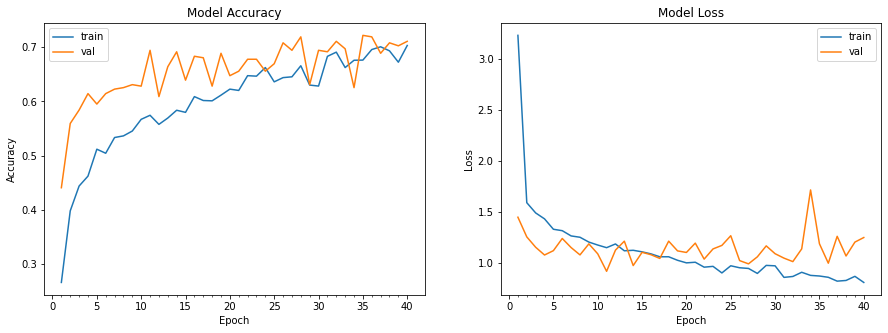

In [9]:
plot_model_history(vgghist)

In [10]:
vggmodel.save('/content/gdrive/MyDrive/vgg16modelclassification.h5')